In [1]:
#imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

In [2]:
# import data
df = pd.read_csv('/Users/gabrielwarner/Downloads/pgaTourData.csv')
df.head()

,Player Name,Rounds,Fairway Percentage,Year,Avg Distance,gir,Average Putts,Average Scrambling,Average Score,Points,Wins,Top 10,Average SG Putts,Average SG Total,SG:OTT,SG:APR,SG:ARG,Money
0,Henrik Stenson,60.0,75.19,2018,291.5,73.51,29.93,60.67,69.617,868,NaN,5.0,-0.207,1.153,0.427,0.960,-0.027,"$2,680,487"
1,Ryan Armour,109.0,73.58,2018,283.5,68.22,29.31,60.13,70.758,"1,006",1.0,3.0,-0.058,0.337,-0.012,0.213,0.194,"$2,485,203"
2,Chez Reavie,93.0,72.24,2018,286.5,68.67,29.12,62.27,70.432,"1,020",NaN,3.0,0.192,0.674,0.183,0.437,-0.137,"$2,700,018"
3,Ryan Moore,78.0,71.94,2018,289.2,68.80,29.17,64.16,70.015,795,NaN,5.0,-0.271,0.941,0.406,0.532,0.273,"$1,986,608"
4,Brian Stuard,103.0,71.44,2018,278.9,67.12,29.11,59.23,71.038,421,NaN,3.0,0.164,0.062,-0.227,0.099,0.026,"$1,089,763"


### Data Cleaning

In [3]:
# Replace NaN with 0 in Top 10 
df['Top 10'].fillna(0, inplace=True)
df['Top 10'] = df['Top 10'].astype(int)

# Replace NaN with 0 in # of wins
df['Wins'].fillna(0, inplace=True)
df['Wins'] = df['Wins'].astype(int)

#Replace any ? with Nan
data = df.replace("?", "np.Nan")

# Drop NaN values 
df.dropna(axis = 0, inplace=True)


In [4]:
# Remove the $ and commas in money 
df['Money'] = df['Money'].apply(lambda x: x.replace('$',''))
df['Money'] = df['Money'].apply(lambda x: x.replace(',',''))
df['Money'] = df['Money'].astype(float)

In [5]:
# Change Money from float64 to numeric
df['Money'] = pd.to_numeric(df.Money, errors='coerce')

### Examine Feature Correlation

In [6]:
# Check correlation to Money
df.corr()['Money']

Rounds                0.278091
Fairway Percentage    0.016237
Year                  0.108244
Avg Distance          0.329295
gir                   0.313770
Average Putts        -0.257832
Average Scrambling    0.317777
Average Score        -0.746499
Wins                  0.721665
Top 10                0.827215
Average SG Putts      0.278895
Average SG Total      0.747042
SG:OTT                0.441912
SG:APR                0.510740
SG:ARG                0.278901
Money                 1.000000
Name: Money, dtype: float64

<AxesSubplot:>

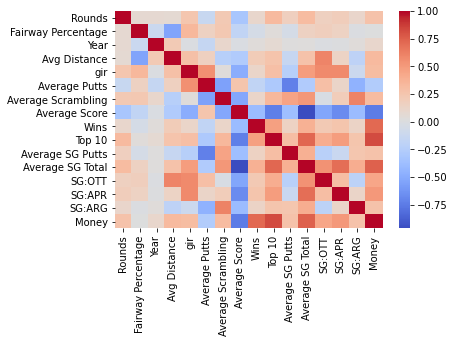

In [7]:
# Plot the correlation matrix between variables 
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            cmap='coolwarm')

### Define Features

In [8]:
# Seperate Target and Features
# Target
y = (df.Money > 500000).astype(int)
# Features
X = df.drop(['Average Putts', 'Year', 'SG:APR', 'Average Score', 'Rounds', 'Average SG Putts', 'Player Name', 'Points', 'Wins', 'Top 10', 'SG:OTT', 'SG:ARG', 'Money'], axis=1)

In [9]:
X.head()

,Fairway Percentage,Avg Distance,gir,Average Scrambling,Average SG Total
0,75.19,291.5,73.51,60.67,1.153
1,73.58,283.5,68.22,60.13,0.337
2,72.24,286.5,68.67,62.27,0.674
3,71.94,289.2,68.80,64.16,0.941
4,71.44,278.9,67.12,59.23,0.062


### Preprocess the Data for Modeling

In [10]:
# Initial Train-Test Split
X_tr, X_test, y_tr, y_test = train_test_split(X, y, random_state=2021)

In [11]:
# Make second split
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=.15, random_state=2021)

In [12]:
#initiate simple imputer
imputer = SimpleImputer(strategy='mean')

In [13]:
# fit to training data
imputer.fit(X_train)

SimpleImputer()

In [14]:
# Convert X_train_imputed and X_val_imputed to a data frame
X_train_imputed = pd.DataFrame(imputer.transform(X_train), columns=X.columns)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X.columns)

In [15]:
# Check for missing values
print("X_train missing: ", X_train_imputed.isna().sum().sum())
print('X_val missing: ', X_val_imputed.isna().sum().sum())

X_train missing:  0
X_val missing:  0


In [16]:
# Make DF with numeric columns
num_cols = list(X.select_dtypes('number').columns)
num_cols

['Fairway Percentage',
 'Avg Distance',
 'gir',
 'Average Scrambling',
 'Average SG Total']

In [17]:
# Instantiate StandardScaler
scaler = StandardScaler()

In [18]:
# fit on Imputed training data
scaler.fit(X_train_imputed)

StandardScaler()

In [19]:
# transform training and validation data
X_train_scaled = pd.DataFrame(scaler.transform(X_train_imputed))
X_val_scaled = pd.DataFrame(scaler.transform(X_val_imputed))

In [20]:
# Define a modeling function
def modeling_function(model, X_train_scaled, y_train, X_val_scaled, y_val):

    # fit model on training data
    model.fit(X_train_scaled, y_train)

    # make predictions on training and validation data
    train_preds = model.predict(X_train_scaled)
    val_preds = model.predict(X_val_scaled)
   
    # Print accuracy score
    print('Training accuracy: ', accuracy_score(y_train, train_preds))
    print('Validation accuracy: ', accuracy_score(y_val, val_preds))

    # return fitted model
    return model

### Logistic Regression

In [21]:
lr = LogisticRegression()

In [22]:
# Call modeling function and pass through training and validation data
dt = modeling_function(lr, X_train_scaled, y_train, X_val_scaled , y_val)

Training accuracy:  0.8583489681050657
Validation accuracy:  0.8888888888888888


#### Scoring

In [23]:
# import recall score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [24]:
# fit model on training data
lr.fit(X_train_scaled, y_train)

    # make predictions on training and validation data
train_preds = lr.predict(X_train_scaled)
val_preds = lr.predict(X_val_scaled)
# get recall score
lr_recall_score_train = recall_score(y_train, train_preds)
lr_recall_score_val = recall_score(y_val, val_preds)
# get accuracy score
lr_accuracy_score_train = accuracy_score(y_train, train_preds)
lr_accuracy_score_val = accuracy_score(y_val, val_preds)

# get precission score
lr_precision_score_train = precision_score(y_train, train_preds)
lr_precision_score_val = precision_score(y_val, val_preds)

In [25]:
# check the data type
lr_recall_score_train.dtype

dtype('float64')

### Logistic Regression with SMOTE

In [26]:
# look for class imbalence
y.value_counts()

1    1308
0     366
Name: Money, dtype: int64

In [27]:
# import SMOTE
from imblearn.over_sampling import SMOTE

In [28]:
# initiate model
sm = SMOTE(random_state=2021)

In [29]:
# resample train for X and Y
X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train)

In [30]:
# check for class imbalence
y_train_res.value_counts()

1    837
0    837
Name: Money, dtype: int64

In [31]:
# initiate logistic regression model
logreg2 = LogisticRegression(random_state=42, C=0.5, max_iter=1000)

In [32]:
# pass through modeling function
logreg_smote = modeling_function(logreg2, X_train_scaled, y_train, X_val_scaled , y_val)

Training accuracy:  0.8564727954971857
Validation accuracy:  0.8888888888888888


In [33]:
# import confusion matrix 
from sklearn.metrics import plot_confusion_matrix

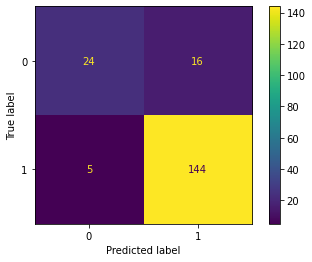

In [34]:
plot_confusion_matrix(logreg_smote, X_val_scaled, y_val)

In [35]:
# SMOTE does not help the mdoel

#### Scoring

In [36]:
# fit model on training data
logreg2.fit(X_train_scaled, y_train)

    # make predictions on training and validation data
train_preds = logreg2.predict(X_train_scaled)
val_preds = logreg2.predict(X_val_scaled)
# get recall score
logreg2_recall_score_train = recall_score(y_train, train_preds)
logreg2_recall_score_val = recall_score(y_val, val_preds)
# get accuracy score
logreg2_accuracy_score_train = accuracy_score(y_train, train_preds)
logreg2_accuracy_score_val = accuracy_score(y_val, val_preds)
# get precision score
logreg2_precision_score_train = precision_score(y_train, train_preds)
logreg2_precision_score_val = precision_score(y_val, val_preds)

### KNN

In [37]:
#import KNN Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
# Initiate model
knn = KNeighborsClassifier(3)
# Run through modeling function
knn_model = modeling_function(knn, X_train_scaled, y_train, X_val_scaled , y_val)

Training accuracy:  0.9024390243902439
Validation accuracy:  0.8571428571428571


#### Scoring

In [38]:
# fit model on training data
knn.fit(X_train_scaled, y_train)

    # make predictions on training and validation data
train_preds = knn.predict(X_train_scaled)
val_preds = knn.predict(X_val_scaled)
# get recall score
knn_recall_score_train = recall_score(y_train, train_preds)
knn_recall_score_val = recall_score(y_val, val_preds)
# get accuracy score
knn_accuracy_score_train = accuracy_score(y_train, train_preds)
knn_accuracy_score_val = accuracy_score(y_val, val_preds)

# get precision score
knn_precision_score_train = precision_score(y_train, train_preds)
knn_precision_score_val = precision_score(y_val, val_preds)

### Decision Tree

In [39]:
# Initiate Decision Tree
dt = DecisionTreeClassifier(random_state=2021)

In [40]:
# Call modeling function and pass through training and validation data
dt = modeling_function(dt, X_train_scaled, y_train, X_val_scaled , y_val)

Training accuracy:  1.0
Validation accuracy:  0.8306878306878307


#### Scoring

In [41]:
# fit model on training data
dt.fit(X_train_scaled, y_train)

    # make predictions on training and validation data
train_preds = dt.predict(X_train_scaled)
val_preds = dt.predict(X_val_scaled)
# get recall score
dt_recall_score_train = recall_score(y_train, train_preds)
dt_recall_score_val = recall_score(y_val, val_preds)
# get accuracy score
dt_accuracy_score_train = accuracy_score(y_train, train_preds)
dt_accuracy_score_val = accuracy_score(y_val, val_preds)

# get precision score
dt_precision_score_train = precision_score(y_train, train_preds)
dt_precision_score_val = precision_score(y_val, val_preds)

### XG Boost

In [42]:
# Import xgboost
from xgboost import XGBClassifier

In [43]:
# Initiate XGB
clf = XGBClassifier()

In [44]:
# Fit training data
clf.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [45]:
# Run model on training and validation data
training_preds = clf.predict(X_train_scaled)
test_preds = clf.predict(X_val_scaled)

In [46]:
# Get training and testing acuracy
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_val, test_preds)

In [47]:
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 100.0%
Validation accuracy: 86.24%


#### Scoring

In [48]:
# fit model on training data
clf.fit(X_train_scaled, y_train)

    # make predictions on training and validation data
train_preds = clf.predict(X_train_scaled)
val_preds = clf.predict(X_val_scaled)
# get recall score
clf_recall_score_train = recall_score(y_train, train_preds)
clf_recall_score_val = recall_score(y_val, val_preds)
# get accuracy score
clf_accuracy_score_train = accuracy_score(y_train, train_preds)
clf_accuracy_score_val = accuracy_score(y_val, val_preds)
# get precision score
clf_precision_score_train = precision_score(y_train, train_preds)
clf_precision_score_val = precision_score(y_val, val_preds)

print('')
print('Training Recall: {:.4}%'.format(clf_recall_score_train * 100))
print('Validation Recall: {:.4}%'.format(clf_recall_score_val * 100))


Training Recall: 100.0%
Validation Recall: 95.3%


### XGBoost tuning

In [49]:
# Create paramiter grid to do hyperperamiter tuning
param_grid = {
    'learning_rate': [0.04, 0.05, 0.1],
    'max_depth': [7],
    'min_child_weight': [1, 2.5],
    'subsample': [0.5, 0.6, 0.7],
    'n_estimators': [225, 250, 275],
}

In [50]:
# Initiate grid search
grid_clf = GridSearchCV(clf, param_grid, scoring='accuracy', cv=None, n_jobs=1)
# Fit to training data
grid_clf.fit(X_train_scaled, y_train)
# Get the best parameters
best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))
# Run model through training and validation data
training_preds = grid_clf.predict(X_train_scaled)
test_preds = grid_clf.predict(X_val_scaled)
# Calculate training and test accuracy for model
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_val, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.04
max_depth: 7
min_child_weight: 1
n_estimators: 250
subsample: 0.5

Training Accuracy: 98.03%
Validation accuracy: 87.83%


#### Scoring

In [ ]:
# fit model on training data
grid_clf.fit(X_train_scaled, y_train)

    # make predictions on training and validation data
train_preds = grid_clf.predict(X_train_scaled)
val_preds = grid_clf.predict(X_val_scaled)
# get recall score
grid_clf_recall_score_train = recall_score(y_train, train_preds)
grid_clf_recall_score_val = recall_score(y_val, val_preds)
# get accuracy score
grid_clf_accuracy_score_train = accuracy_score(y_train, train_preds)
grid_clf_accuracy_score_val = accuracy_score(y_val, val_preds)
# get precision score
grid_clf_precision_score_train = precision_score(y_train, train_preds)
grid_clf_precision_score_val = precision_score(y_val, val_preds)

print('')
print('Training Recall: {:.4}%'.format(grid_clf_recall_score_train * 100))
print('Validation Recall: {:.4}%'.format(grid_clf_recall_score_val * 100))

### Support vector Machine

In [ ]:
from sklearn.svm import SVC

In [ ]:
#poly kernel must pass in degree 
svm = SVC(kernel='poly', degree=3)
clf.fit(X_train_scaled, y_train)

In [ ]:
y_pred = clf.predict(X_val_scaled)

In [ ]:
#training_accuracy = accuracy_score(y_train, y_pred)

In [ ]:
# Call modeling function and pass through training and validation data
svm = modeling_function(clf, X_train_scaled, y_train, X_val_scaled , y_val)

### Scoring

In [ ]:
# fit model on training data
svm.fit(X_train_scaled, y_train)

    # make predictions on training and validation data
train_preds = svm.predict(X_train_scaled)
val_preds = svm.predict(X_val_scaled)
# get recall score
svm_recall_score_train = recall_score(y_train, train_preds)
svm_recall_score_val = recall_score(y_val, val_preds)
# get accuracy score
svm_accuracy_score_train = accuracy_score(y_train, train_preds)
svm_accuracy_score_val = accuracy_score(y_val, val_preds)
# get precision score
svm_precision_score_train = precision_score(y_train, train_preds)
svm_precision_score_val = precision_score(y_val, val_preds)
print('')
print('Training Recall: {:.4}%'.format(svm_recall_score_train * 100))
print('Validation Recall: {:.4}%'.format(svm_recall_score_val * 100))

### Best Model (Logistic Regression)

In [ ]:
# Create data frame for X_test
X_test_imputed = pd.DataFrame(imputer.transform(X_test), columns=X.columns)

In [ ]:
# Scale testing data
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed))

In [ ]:
# Run testing data through model
test_preds = lr.predict(X_test_scaled)

In [ ]:
# Get the accuracy score
accuracy_score(y_test, test_preds)

In [ ]:
recall_score(y_test, test_preds)

In [ ]:
plot_confusion_matrix(grid_clf, X_val_scaled, y_val)

# Model Preformance Examination (Confusion Matrix)

### Logistic Regression

In [ ]:
plot_confusion_matrix(lr, X_val_scaled, y_val)

In [ ]:
from sklearn.metrics import recall_score

### Logistic Regression with SMOTE

In [ ]:
plot_confusion_matrix(logreg2, X_val_scaled, y_val)

### KNN

In [ ]:
plot_confusion_matrix(knn, X_val_scaled, y_val)

### Decision Tree

In [ ]:
plot_confusion_matrix(dt, X_val_scaled, y_val)

### XG Boost

In [ ]:
plot_confusion_matrix(clf, X_val_scaled, y_val)

### Support vector Machine

In [ ]:
plot_confusion_matrix(svm, X_val_scaled, y_val)

### XGBoost tuning

In [ ]:
plot_confusion_matrix(grid_clf, X_val_scaled, y_val)

### Recall Training and Validation Data graph

In [ ]:
# Create DF with validation/training recall score
d = {'Training': [(lr_recall_score_train), (logreg2_recall_score_train), (knn_recall_score_train), (dt_recall_score_train), (clf_recall_score_train), (grid_clf_recall_score_train), (svm_recall_score_train)], 'Validation': [(lr_recall_score_val), (logreg2_recall_score_val), (knn_recall_score_val), (dt_recall_score_val), (clf_recall_score_val), (grid_clf_recall_score_val), (svm_recall_score_val)]}
# create new data frame with data from above
train_val_recall = pd.DataFrame(data=d)
train_val_recall

In [ ]:
# make sea born double line graph
g = sns.lineplot(data=train_val_recall)
plt.xticks(rotation = 60)
g.set(title='Recall Score')
g.set_xticklabels(['logistic regression', 'logistic regression', ' SMOTE logistic regression', 'KNN', 'Decision Tree', 'XG Boost', 'XG Boost Tuned', 'Support Vector Machine'])

### Accuracy Training and Validation Graph

In [ ]:
# Create DF with validation/trainign accuracy score
d2 = {'Training': [(lr_accuracy_score_train), (logreg2_accuracy_score_train), (knn_accuracy_score_train), (dt_accuracy_score_train), (clf_accuracy_score_train), (grid_clf_accuracy_score_train), (svm_accuracy_score_train)], 'Validation': [(lr_accuracy_score_val), (logreg2_accuracy_score_val), (knn_accuracy_score_val), (dt_accuracy_score_val), (clf_accuracy_score_val), (grid_clf_accuracy_score_val), (svm_accuracy_score_val)]}
train_val_accuracy = pd.DataFrame(data=d2)
train_val_accuracy


In [ ]:
# create seaborn double line graph
g2 = sns.lineplot(data=train_val_accuracy)
plt.xticks(rotation = 60)
g2.set(title='Accuracy Score')
g2.set_xticklabels(['logistic regression', 'logistic regression', ' SMOTE logistic regression', 'KNN', 'Decision Tree', 'XG Boost', 'XG Boost Tuned', 'Support Vector Machine'])

### Precision Training and Validation Graph

In [ ]:
# Create DF with validation/trainign accuracy score
g3 = {'Training': [(lr_precision_score_train), (logreg2_precision_score_train), (knn_precision_score_train), (dt_precision_score_train), (clf_precision_score_train), (grid_clf_precision_score_train), (svm_precision_score_train)], 'Validation': [(lr_precision_score_val), (logreg2_precision_score_val), (knn_precision_score_val), (dt_precision_score_val), (clf_precision_score_val), (grid_clf_precision_score_val), (svm_precision_score_val)]}
train_val_precision = pd.DataFrame(data=g3)
train_val_precision


In [ ]:
# create seaborn double line graph
g3 = sns.lineplot(data=train_val_accuracy)
plt.xticks(rotation = 60)
g3.set(title='Precision Score')
g3.set_xticklabels(['logistic regression', 'logistic regression', ' SMOTE logistic regression', 'KNN', 'Decision Tree', 'XG Boost', 'XG Boost Tuned', 'Support Vector Machine'])